## Analyze overlapping between CUMULO prediction and RICC
Figure.17 in [T.Kurihana et al. 2021](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9497325) 

In [2]:
%matplotlib inline
# conda env; mpi-cloud
import os
import re
import gc
import cv2
import math
import glob
import pickle
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.data.experimental import parallel_interleave
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

In [3]:
import seaborn as sns

In [4]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors

In [5]:
import multiprocessing
from multiprocessing import Pool
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
import sys
libdir = '/home/tkurihana/Research/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from analysis_lib import _get_colors

In [7]:
def importNetcdf(path=None, var_name=None):
    nc_fid=Dataset(path, 'r')
    field = nc_fid.variables[var_name][:]
    return field

In [8]:
def data_extractor_fn(filelist,prefetch=1,read_threads=4, distribute=(1, 0), shape_size=2):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """

        features = {
            "shape": tf.FixedLenFeature([shape_size], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }        
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        coord=decoded["coordinate"]
        return patch, coord
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=False)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patch_list = []
    coord_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch, coord = sess.run(next_element)
                patch_list.append(patch)
                coord_list.append(coord)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patch_list, coord_list

#### Load clustering dataset

In [9]:
#nclusters_list = [8,16,32,64,128]
nclusters_list = [12]

In [10]:
#layer_names = [ 'leaky_re_lu_15',  'leaky_re_lu_23']  # for first try
layer_names = ['leaky_re_lu_23']

### 1  New code with file map processing
##### large_hac2 >  Load data

In [11]:
label_results = {}
databasedir = '/home/tkurihana/Research/CUMULO/clustering/large_hac2'  # large_hac1
for nclusters in nclusters_list:
    tmp_label_results = {}
    
    for layer_name in layer_names:
            hac_datadir = f"{databasedir}/67011582/nclusters-{nclusters}/HAC/{layer_name}/20080101"
        
            # load data
            with open(os.path.join(hac_datadir,"score-hac_67011582.pkl"), 'rb') as f:
                results = pickle.load(f)
            tmp_label_results[f"{layer_name}-labels"] = results[f'{layer_name}-labels']
    label_results[f"{nclusters}"] = tmp_label_results
    print(f"NORMAL END: NCLUSTER {nclusters}")

NORMAL END: NCLUSTER 12


In [12]:
label_results.keys()

dict_keys(['12'])

In [13]:
label_results['12'].keys()

dict_keys(['leaky_re_lu_23-labels'])

In [14]:
label_results['12']['leaky_re_lu_23-labels'].shape  # lables

(58734,)

###### Prep before overlapping 

Get fileorder file

In [13]:
fileorder = np.load("./sort_file_names_20080101.npy") # order of file

In [65]:
fileorder[0]

'/home/tkurihana/Research/data3/clouds_MYD_laads_multiprocessed_20080101_timestamp_stride/MYD021KM.A2008001.0035.061.2018031002501.tfrecord'

In [14]:
tf_datadir = "/home/tkurihana/Research/data3/clouds_MYD_laads_multiprocessed_20080101_timestamp_stride" # stride 64

In [15]:
coords_list = []
for i in fileorder:
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    ifile = os.path.join(tf_datadir, f"{fbasename}.tfrecord")
    _, tmp_coord_list = data_extractor_fn([ifile], shape_size=3)
    coords_list.append(tmp_coord_list)
gc.collect()

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> fini

8752

In [21]:
gc.collect()

0

-----------
##### Gen-Data and Main run for large_hac2 > or higher

In [17]:
def split_label_fn(clabels=None, patch_size = 128):
    split_clabels_list = []
    index = 0
    for i in coords_list:
        length = len(i)
        tmp_labels = clabels[index:index+length]
        # multiply patch size
        tmp_list = []
        for ilabel in tmp_labels:
            for j in range(patch_size * patch_size):
                tmp_list.append(ilabel)
        split_clabels_list.append(tmp_list)
        index += length
    return split_clabels_list

In [18]:
def comp_class_occurrences(labels=None,nclusters=None, coord_list=None, oheight=2030, owidth=1354,patch_size=128):
    occs = np.ones((oheight, owidth, nclusters)).astype(np.int8) *-1  # default is -1
    
    split_labels = np.array_split(labels, len(coord_list)) 
    for (x,y), lab in zip(coord_list, split_labels):
        nelem = 0
        for i in range(patch_size):
            for j in range(patch_size):
                ilab = lab[nelem]
                tmp = occs[x+i,y+j, int(ilab)]
                if tmp == -1:
                    occs[x+i,y+j, int(ilab)] =1
                else:
                    occs[x+i,y+j, int(ilab)] +=1
                nelem+=1
    freq = np.nanargmax(occs, axis=-1)
    neg_idx = np.where(np.all(occs<0, axis=-1))
    #print(neg_idx); stop
    freq[neg_idx] = -1
    return freq

RUN!

In [22]:
### config
nproc = 4

In [23]:
gc.collect()

0

In [33]:
#def run(_labels=None, _coord_list=None, nclusters=None, savedatadir=None, outputbasename=None):
def run(inputs):
    _labels,_coord_list,nclusters,savedatadir,outputbasename = inputs
    print(len(_labels), len(_coord_list), nclusters, savedatadir, outputbasename)
    freq = comp_class_occurrences(labels=_labels,nclusters=nclusters, coord_list=_coord_list)
    print(freq.shape)
    
    # save 
    os.makedirs(savedatadir, exist_ok=True)
    outputname = outputbasename.strip('.tfrecord')
    np.savez(os.path.join(savedatadir, outputname), freq)

if __name__ == "__main__":
    
    for nclusters in [12]: #[16,32,64]:
        print("### ", nclusters)
        # prep data
        clabels = label_results[f'{nclusters}']['leaky_re_lu_23-labels']
        split_clabels_list = split_label_fn(clabels)
        basefnames = [os.path.basename(i) for i in fileorder]
        savedatadir = f'./large_hac2/67011582/nclusters-{nclusters}/HAC/leaky_re_lu_23/cluster_map'    
        print('check for debug', len(split_clabels_list), len(coords_list), len(basefnames))
        gc.collect()
        
        print(f"START RUNNING {nclusters}")
        #  MAIN RUN
        p = Pool(nproc) 
        args = [(lab, cords, nclusters, savedatadir, bns) for (lab, cords, bns) in zip(
            split_clabels_list, coords_list, basefnames)]
        result = p.map(run, args) 
        gc.collect()

###  12
check for debug 155 155 155
START RUNNING 12
2588672 158 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0035.061.2018031002501.tfrecord
2801664 171 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0125.061.2018031001713.tfrecord
8716288 532 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0300.061.2018031001817.tfrecord
7553024 461 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0435.061.2018031001922.tfrecord
(2030, 1354)
7012352 428 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0040.061.2018031002452.tfrecord
(2030, 1354)
5144576 314 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0215.061.2018031002448.tfrecord
(2030, 1354)
9142272 558 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0440.061.2018031001616.

(2030, 1354)
2883584 176 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0720.061.2018031002434.tfrecord
(2030, 1354)
5521408 337 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0855.061.2018031002457.tfrecord
(2030, 1354)
8503296 519 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.1110.061.2018031001845.tfrecord
(2030, 1354)
9682944 591 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0725.061.2018031002520.tfrecord
(2030, 1354)
1277952 78 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0940.061.2018031002614.tfrecord
(2030, 1354)
6176768 377 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.1030.061.2018031002710.tfrecord
(2030, 1354)
3407872 208 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.0900.061.2018031002536.tf

(2030, 1354)
9420800 575 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.1855.061.2018031002602.tfrecord
(2030, 1354)
5275648 322 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.1535.061.2018031002455.tfrecord
(2030, 1354)
8126464 496 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.1750.061.2018031002243.tfrecord
(2030, 1354)
2850816 174 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.1615.061.2018031002700.tfrecord
(2030, 1354)
3309568 202 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.2025.061.2018031002815.tfrecord
(2030, 1354)
966656 59 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.1705.061.2018031030535.tfrecord
(2030, 1354)
7929856 484 12 ./large_hac2/67011582/nclusters-12/HAC/leaky_re_lu_23/cluster_map MYD021KM.A2008001.1900.061.2018031002759.tfr

Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
  File "/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap

In [34]:
del clabels
gc.collect()

0

### 2 Alignment CUMULO and RI autoencoder at pixel-wise

#### Load CUMULO predictions

In [35]:
netcdf_datadir = "/home/tkurihana/Research/data3/200801/day"

In [38]:
npy_datadir = "/home/tkurihana/Research/CUMULO/ml-examples/results/iresnet/6176413/best/predicted-label-masks/2008001"

In [39]:
cumulo = []
idx = 20
for idx, i in enumerate(fileorder):
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    fbname = re.findall(r'A[0-9]{7}.[0-9]{4}', fbasename)[0].split('.')
    ctime = fbname[1]
    
    # CUMULO
    cumulo.append(np.load(os.path.join(npy_datadir, f"A2008.001.{ctime}.npy"))) # (1354  , 2030)
    if idx % 20 == 0:
        print(f"{idx} files read done!", flush=True)
        gc.collect()

0 files read done!
20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!


In [40]:
cumulo[0].shape

(1354, 2030)

### Load NetCDF4 file to load cloud pixel flags (2020/12/29 for paper)

In [66]:
nc_datadir = '/home/tkurihana/Research/data3/200801/day'

In [117]:
clouds_pixels = []
idx = 20
for idx, i in enumerate(fileorder):
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    fbname = re.findall(r'A[0-9]{7}.[0-9]{4}', fbasename)[0].split('.')
    ctime = fbname[1]
    
    # CUMULO
    cp_ncdf = importNetcdf(os.path.join(nc_datadir, f"A2008.001.{ctime}.nc"), 'cloud_mask')
    cp_array = np.array(cp_ncdf)
    ncpidx = np.where(cp_array == 0)
    cp_array[ncpidx] = -1
    clouds_pixels.append(np.squeeze(cp_array)) # (1354  , 2030)
    if idx % 20 == 0:
        print(f"{idx} files read done!", flush=True)
        gc.collect()

0 files read done!
20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!


#### Load integrated labels

In [41]:
nclusters_list = [12]  #[8,16,32,64,128]

In [118]:
mut_label_dict = {}
for nclusters in nclusters_list:
    npz_datadir = f'./large_hac2/67011582/nclusters-{nclusters}/HAC/leaky_re_lu_23/cluster_map'
    
    mut_clabels = []
    for i in fileorder:
        fbasename = os.path.basename(i).rstrip('.tfrecord')
        ifile = os.path.join(npz_datadir, f"{fbasename}.npz")
        array = np.load(ifile)['arr_0']  #  (2030, 1354)
        #print(array.shape, type(array[0,0]), array[0,0] ); stop
        mut_clabels.append(array)
    mut_label_dict[f'{nclusters}'] = mut_clabels
    print(f" Cluster {nclusters} finish!")

 Cluster 12 finish!


In [43]:
len(mut_label_dict['12']), len(cumulo)

(155, 155)

In [119]:
gc.collect()

117

#### CUMULO ratio per cluster

In [45]:
def eval_fn(select_data, mut_clabels, nclusters=None, cumulos=8, ):
    indv_scores = {}
    sdata = np.array(select_data)
    mlabels = np.array(mut_clabels)
    for icluster in range(nclusters):
        idx = np.where(mlabels == icluster)
        _sdata = sdata[idx]
        tmp = {}
        for i in range(cumulos):
            tmp[f"nc-{i}"] = len(np.where(_sdata == i)[0] )
        indv_scores[f"{icluster}"] = tmp
        #print(f" Cluster {icluster} finish!")
    return indv_scores

In [120]:
nclusters_list = [12]  #[8,16,32,64,128]

In [121]:
### compute results
dict_ratios = {}
for nclusters in nclusters_list:
    for layer_name in layer_names:
        c_mut_clabels = mut_label_dict[f'{nclusters}']
        # operate
        df_ratio_list = []
        for idx, (_cumulo, _c_mut_clabels) in enumerate(zip(cumulo, c_mut_clabels)):
            # load cumulo and T
            _cumuloT = _cumulo.T
            
            # [2020/12/29] load cloud pixel --------------------
            cloud_flags = clouds_pixels[idx].T
            check_array = _cumuloT
            _cumuloT = _cumuloT * cloud_flags 
            #-------------------------------------
            
            tmp_df_ratio = pd.DataFrame(eval_fn(
                _cumuloT, _c_mut_clabels, nclusters=nclusters, cumulos=8
                )
            )
            if idx == 0:
                df_ratio = tmp_df_ratio
            else:
                df_ratio = df_ratio + tmp_df_ratio
            
        dict_ratios[f'{layer_name}-{nclusters}'] = df_ratio
    print(f" Cluster {nclusters} finish!")

 Cluster 12 finish!


-----------------------------------
### 3.  See results
df = (dict_ratios[f'{column_name}'] / dict_ratios[f'{column_name}'].sum()) * 100

In [129]:
dict_ratios.keys()

dict_keys(['leaky_re_lu_23-12'])

In [46]:
dict_ratios['leaky_re_lu_23-8']

,0,1,2,3,4,5,6,7
nc-0,15936236,5487269,4160093,10674080,10432950,5460782,6926048,5464440
nc-1,14551958,158799,4821124,2461655,1402499,15619,290533,5216689
nc-2,3323989,6327090,2835829,4024137,4668968,8338827,3687079,2410737
nc-3,193345,5110849,2956462,1483966,3901528,747850,383905,1586007
nc-4,4162009,19553555,14131719,15360806,12456440,33665449,9289154,10930842
nc-5,324963,702451,405180,553955,452931,3172141,600462,316208
nc-6,8808108,3219,8114745,253305,230924,36,3235,4111045
nc-7,0,0,0,0,0,0,0,0


In [49]:
dict_ratios['leaky_re_lu_23-12'] # before consider non cloud pixel

,0,1,2,3,4,5,6,7,8,9,10,11
nc-0,12587613,13245510,2363923,7069802,4302718,5385088,7305639,3278026,896448,3977584,2741145,1388402
nc-1,2485190,7029620,5562806,301109,4157992,18770,1200423,3003836,9594,4967439,173436,8661
nc-2,5417151,3242028,148662,5183700,1592384,6982191,2626593,1936129,1980239,2501524,1730030,2276025
nc-3,4055196,312598,2551,1593231,663898,526149,857201,3703665,2755137,370480,436377,1087429
nc-4,13839274,5283980,126935,10458695,5365016,29685308,8255232,14096739,8288094,9255182,7276981,7618538
nc-5,525266,354715,12042,610299,190131,2986851,333864,271574,234456,349506,361528,298059
nc-6,588038,2349277,4480681,2236,3433717,27,114040,1136847,0,9417069,2679,6
nc-7,0,0,0,0,0,0,0,0,0,0,0,0


In [131]:
dict_ratios['leaky_re_lu_23-12'] # after consider non cloud pixel

,0,1,2,3,4,5,6,7,8,9,10,11
nc-0,12587613,13245510,2363923,7069802,4302718,5385088,7305639,3278026,896448,3977584,2741145,1388402
nc-1,2373041,5918230,4999406,298373,3138719,18707,1184323,2782306,9586,4440183,169167,8658
nc-2,5120297,2353510,83528,3274785,974760,2797215,1699940,1472922,1291634,1513844,761661,1039774
nc-3,4044905,307738,2551,1540617,630336,517241,843482,3098146,2724669,291572,434798,1066677
nc-4,13150023,3778683,49397,7575515,3100035,12935208,5544497,9705420,7470415,5835474,3467369,5055895
nc-5,490131,255326,5855,320563,119866,645494,187770,192988,162715,200361,120377,95231
nc-6,576891,2098447,3919579,2236,2684414,27,113983,1035965,0,8646821,2679,6
nc-7,0,0,0,0,0,0,0,0,0,0,0,0


In [132]:
def get_ratio(df):
    for idx in df.columns:
        df[f"{idx}"] = (df[f"{idx}"]/df[f"{idx}"].sum())*100
        df[f"{idx}"] = df[f"{idx}"].round(2)
    return df

In [50]:
df_cratio = get_ratio(dict_ratios['leaky_re_lu_23-8'])

In [51]:
df_cratio

,0,1,2,3,4,5,6,7
nc-0,33.69,14.69,11.12,30.66,31.10,10.62,32.70,18.19
nc-1,30.76,0.43,12.88,7.07,4.18,0.03,1.37,17.37
nc-2,7.03,16.94,7.58,11.56,13.92,16.22,17.41,8.03
nc-3,0.41,13.69,7.90,4.26,11.63,1.45,1.81,5.28
nc-4,8.80,52.36,37.76,44.13,37.13,65.50,43.86,36.39
nc-5,0.69,1.88,1.08,1.59,1.35,6.17,2.83,1.05
nc-6,18.62,0.01,21.68,0.73,0.69,0.00,0.02,13.69
nc-7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [133]:
df_cratio = get_ratio(dict_ratios['leaky_re_lu_23-12'])

In [134]:
df_cratio

,0,1,2,3,4,5,6,7,8,9,10,11
nc-0,32.83,47.38,20.69,35.20,28.78,24.15,43.28,15.20,7.14,15.97,35.61,16.04
nc-1,6.19,21.17,43.76,1.49,20.99,0.08,7.02,12.90,0.08,17.83,2.20,0.10
nc-2,13.35,8.42,0.73,16.31,6.52,12.54,10.07,6.83,10.29,6.08,9.90,12.01
nc-3,10.55,1.10,0.02,7.67,4.22,2.32,5.00,14.37,21.70,1.17,5.65,12.32
nc-4,34.30,13.52,0.43,37.72,20.73,58.01,32.85,45.00,59.50,23.43,45.05,58.42
nc-5,1.28,0.91,0.05,1.60,0.80,2.89,1.11,0.89,1.30,0.80,1.56,1.10
nc-6,1.50,7.51,34.31,0.01,17.95,0.00,0.68,4.80,0.00,34.72,0.03,0.00
nc-7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### Save as ratio

In [135]:
csv_datadir = './csvs/large_hac2'
os.makedirs(csv_datadir, exist_ok=True)
for ikey in dict_ratios.keys():
    dict_ratios[ikey].to_csv(os.path.join(csv_datadir, f'raw-{ikey}.csv'))
    df = dict_ratios[ikey]
    for idx in dict_ratios[ikey].columns:
        df[f"{idx}"] = (df[f"{idx}"]/df[f"{idx}"].sum())*100
        df[f"{idx}"] = df[f"{idx}"].round(2)
    df.to_csv(os.path.join(csv_datadir, f'ratio-{ikey}.csv'))

### Plot CUMULO ratio graph: stride size 64 i.e. 4 times finer resolution

In [136]:
data_list = []
for nc in [12] :  #[8,16,32,64,128]:
    data_list.append(pd.read_csv(
            f'./csvs/large_hac2/ratio-leaky_re_lu_23-{nc}.csv', index_col=0
        )
    )

In [137]:
adf = data_list[0]
adf.index = ['Ci', 'As', 'Ac', 'St', 'Sc', 'Cu', 'Ns', 'Dc']

In [66]:
adf

,0,1,2,3,4,5,6,7
Ci,33.69,14.69,11.12,30.66,31.10,10.62,32.70,18.19
As,30.76,0.43,12.88,7.07,4.18,0.03,1.37,17.37
Ac,7.03,16.94,7.58,11.56,13.92,16.22,17.41,8.03
St,0.41,13.69,7.90,4.26,11.63,1.45,1.81,5.28
Sc,8.80,52.36,37.76,44.13,37.13,65.51,43.86,36.39
Cu,0.69,1.88,1.08,1.59,1.35,6.17,2.83,1.05
Ns,18.62,0.01,21.68,0.73,0.69,0.00,0.02,13.69
Dc,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [68]:
adf.apply()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Ci,36.92,16.58,10.76,40.07,18.01,44.32,32.72,11.69,30.33,10.12,7.21,19.36,20.78,27.08,21.86,15.65
As,6.83,43.47,0.05,8.26,0.67,27.38,1.63,12.17,6.80,14.13,0.09,8.98,16.32,25.22,0.79,19.82
Ac,15.11,1.90,16.27,11.25,19.29,8.89,16.92,8.05,11.86,6.73,10.94,10.93,8.50,8.35,13.37,7.39
St,4.64,0.01,2.23,4.53,11.66,0.52,1.98,12.03,15.68,0.27,23.34,3.65,7.13,0.49,16.99,1.63
Sc,32.99,1.81,64.88,33.61,48.41,9.76,44.00,46.12,33.33,22.50,57.27,54.43,40.32,13.71,45.63,27.68
Cu,1.56,0.16,5.80,1.29,1.95,0.81,2.72,1.12,1.06,1.01,1.15,1.79,1.13,0.94,1.28,0.97
Ns,1.95,36.07,0.00,1.00,0.01,8.32,0.02,8.81,0.94,45.25,0.00,0.86,5.83,24.20,0.08,26.86
Dc,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [138]:
adf #12

,0,1,2,3,4,5,6,7,8,9,10,11
Ci,32.83,47.38,20.69,35.20,28.78,24.15,43.28,15.20,7.14,15.97,35.61,16.04
As,6.19,21.17,43.76,1.49,20.99,0.08,7.02,12.90,0.08,17.83,2.20,0.10
Ac,13.35,8.42,0.73,16.31,6.52,12.54,10.07,6.83,10.29,6.08,9.90,12.01
St,10.55,1.10,0.02,7.67,4.22,2.32,5.00,14.37,21.70,1.17,5.65,12.32
Sc,34.30,13.52,0.43,37.72,20.73,58.02,32.85,45.00,59.49,23.43,45.05,58.43
Cu,1.28,0.91,0.05,1.60,0.80,2.89,1.11,0.89,1.30,0.80,1.56,1.10
Ns,1.50,7.51,34.31,0.01,17.95,0.00,0.68,4.80,0.00,34.72,0.03,0.00
Dc,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [183]:
### Compute arrya for plotting
threses = [50,40,]

nthres_list = []
for thres in threses: 
    #tmp_ndata_list = []
    tmp_nthres_list = []
    for tmp_data , nclusters in zip(data_list, [8,16,32,64,128]):
        num_thres = 0
        
        for i in range(nclusters):
            ##print(i)
            tmp = tmp_data[f"{i}"]
            #print(tmp)
            nthres = len(np.where(tmp > thres)[0])
            #if thres >= 40:
                #nthres = len(np.where(tmp > thres)[0])
            #else:
            #    nthres = len(np.where((tmp >= thres) & (tmp<=30) )[0])
            if nthres > 0:
                num_thres +=  1 #nthres
        tmp_nthres_list.append(num_thres)
    #tmp_ndata_list.append(tmp_nthres_list)
    nthres_list.append(tmp_nthres_list)

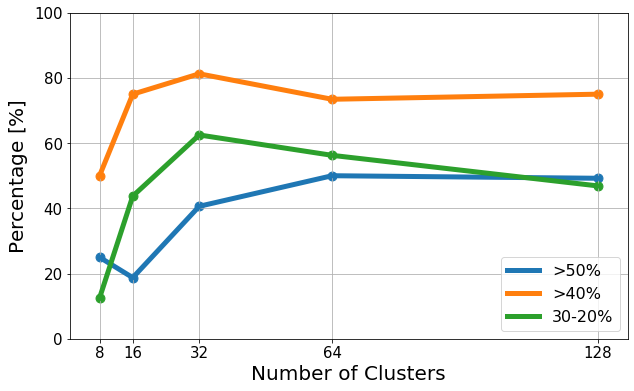

In [58]:
labels = ['>50%', '>40%', '30-20%']
plt.rcParams.update({'font.size': 15})
nclusters = np.array([8,16,32,64,128])

plt.figure(figsize=(10,6))
for idx, thres in enumerate(nthres_list):
    plt.plot([8,16,32,64,128], np.array(thres)/nclusters*100,
             label=labels[idx], linewidth=5)
    plt.scatter([8,16,32,64,128], np.array(thres)/nclusters*100, s=80)
plt.xticks([8,16,32,64,128])
plt.grid(True)
plt.legend(fontsize=16)
plt.ylabel(r'Percentage [$\%$]', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=20)
plt.ylim(0,100)
#plt.show()
pdf = PdfPages(f'./figs/large_hac2_clusterCumuloRatio.pdf')
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

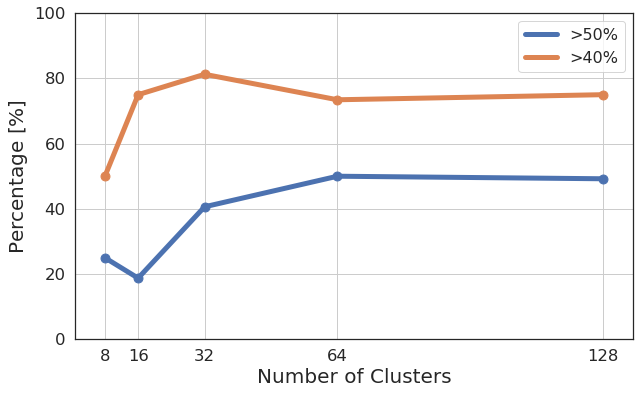

In [184]:
labels = ['>50%', '>40%','>35%',]
plt.rcParams.update({'font.size': 15})
nclusters = np.array([8,16,32,64,128])

plt.figure(figsize=(10,6))
for idx, thres in enumerate(nthres_list):
    plt.plot([8,16,32,64,128], np.array(thres)/nclusters*100,
             label=labels[idx], linewidth=5)
    plt.scatter([8,16,32,64,128], np.array(thres)/nclusters*100, s=80)
plt.xticks([8,16,32,64,128])
plt.grid(True)
plt.legend(fontsize=16)
plt.ylabel(r'Percentage [$\%$]', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=20)
plt.ylim(0,100)
#plt.show()
pdf = PdfPages(f'./figs/large_hac2_clusterCumuloRatio2.pdf')
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

#### 3.1 Look by table

In [18]:
def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [70]:
df_tables_list = []
for i in range(4):
    adf = data_list[i]
    adf.index = ['Ci', 'As', 'Ac', 'St', 'Sc', 'Cu', 'Ns', 'Dc']
    df_tables_list.append(adf)

###### cumulo class names
0. Cirrus and cirrostratus (Ci)
1. Altostratus (As)
2. Altocumulus (Ac)
3. Stratus (St)
4. Stratocumulus (Sc)
5. Cumulus (Cu)
6. Nimbostratus (Ns)
7. Deep Convection (Dc)

In [72]:
df_tables_list[0].style.apply(highlight_max)

,0,1,2,3,4,5,6,7
Ci,33.69,14.69,11.12,30.66,31.1,10.62,32.7,18.19
As,30.76,0.43,12.88,7.07,4.18,0.03,1.37,17.37
Ac,7.03,16.94,7.58,11.56,13.92,16.22,17.41,8.03
St,0.41,13.69,7.9,4.26,11.63,1.45,1.81,5.28
Sc,8.8,52.36,37.76,44.13,37.13,65.51,43.86,36.39
Cu,0.69,1.88,1.08,1.59,1.35,6.17,2.83,1.05
Ns,18.62,0.01,21.68,0.73,0.69,0,0.02,13.69
Dc,0,0,0,0,0,0,0,0


In [73]:
df_tables_list[1].style.apply(highlight_max)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Ci,36.92,16.58,10.76,40.07,18.01,44.32,32.72,11.69,30.33,10.12,7.21,19.36,20.78,27.08,21.86,15.65
As,6.83,43.47,0.05,8.26,0.67,27.38,1.63,12.17,6.8,14.13,0.09,8.98,16.32,25.22,0.79,19.82
Ac,15.11,1.9,16.27,11.25,19.29,8.89,16.92,8.05,11.86,6.73,10.94,10.93,8.5,8.35,13.37,7.39
St,4.64,0.01,2.23,4.53,11.66,0.52,1.98,12.03,15.68,0.27,23.34,3.65,7.13,0.49,16.99,1.63
Sc,32.99,1.81,64.88,33.61,48.41,9.76,44,46.12,33.33,22.5,57.27,54.43,40.32,13.71,45.63,27.68
Cu,1.56,0.16,5.8,1.29,1.95,0.81,2.72,1.12,1.06,1.01,1.15,1.79,1.13,0.94,1.28,0.97
Ns,1.95,36.07,0,1,0.01,8.32,0.02,8.81,0.94,45.25,0,0.86,5.83,24.2,0.08,26.86
Dc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
df_tables_list[2].style.apply(highlight_max)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Ci,10.74,40.7,39.33,6.22,27.3,20.81,41.09,29.68,59.19,16.26,35.08,30.43,9.45,30.19,22.98,10.16,14.91,21.62,15.05,7.15,15.32,28.62,48.62,28.22,61.64,13.34,2.8,4.02,27.07,22.66,18.82,17.33
As,15.19,29.91,3.02,0.05,0.56,8.99,26.5,5.01,15.63,15.25,5.37,5.65,26.88,9.23,1.06,0.12,15.42,70.73,0.02,0.04,17.74,16.56,7.09,0.65,22.06,2.85,0.03,2.8,25.68,0.63,1.66,24.85
Ac,7.01,8.08,18.59,13.31,21.92,10.9,8.56,14.49,9.36,8.14,11.36,15.52,2.26,8.05,14.6,12.83,9.8,0.26,19.2,18.32,7.68,9.52,16.49,16.75,12.19,17.05,8.27,3.86,8.35,12.37,14.23,6.7
St,0.4,0.57,2.57,3.75,4.41,3.43,0.88,7.71,1.19,8.48,5.89,11.16,0.01,19.94,12.75,23.44,4.81,0,0.3,18.78,2.55,4.67,0.7,1.07,0,7.07,22.57,30.91,0.44,20.78,12.65,0.29
Sc,22.72,9.8,34.27,72.61,43.62,53.18,12.84,40.51,12.19,45.18,40.21,35.38,2.05,29.81,47.06,52.36,43.04,0.07,57.18,53.68,35.01,33.6,22.8,49.79,1.58,56.32,65.12,56.85,13.08,42.32,51.15,9.95
Cu,1.02,0.81,2.12,4.06,2.18,1.8,0.81,1.47,0.93,0.98,1.42,1.32,0.2,0.78,1.43,1.08,1.34,0.01,8.24,2.03,1.05,1.47,1.91,3.52,0.56,2.1,1.22,0.64,0.93,1.12,1.49,0.8
Ns,42.93,10.12,0.11,0,0,0.9,9.32,1.14,1.52,5.7,0.65,0.54,59.14,2,0.12,0,10.68,7.3,0,0,20.64,5.56,2.4,0,1.97,1.28,0,0.93,24.46,0.12,0.01,40.08
Dc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
df_tables_list[3].style.apply(highlight_max)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
Ci,13.54,7.65,33.96,15.21,51.13,33.83,53.45,46.71,5.89,38.51,30.26,22.1,2.93,22.27,37.21,41.87,10.97,20.04,12.87,33.52,15.01,17.68,11.58,9.98,5.73,29.32,30.94,36.48,33.72,30.73,10.06,17.37,1.07,15.09,56.5,28.71,21.83,15.11,55.39,8.71,57.48,38.14,13.7,72.27,5.98,71.61,6.2,59.05,67.6,44.6,49.18,25.62,26.67,66.28,11.07,4.41,59.81,1.79,24.73,13.08,19.03,3.54,11.91,22.82
As,0.32,0.11,2.86,0.05,8.43,20.51,1.61,39.85,0.05,21.59,4.71,5.77,0.03,1.81,27.35,10.34,0.74,19.28,15.24,0.58,19.36,0.59,2.67,0.03,0.06,8.05,1.04,30.66,3.11,22.87,0.61,24.99,12.88,15.2,27.38,34.05,68.07,10.18,2.72,0.15,10.61,14.25,11.24,21.47,0.03,20.63,0.21,1.65,8.14,19.72,20.49,3.6,0.98,14.66,1.5,3.5,5.33,22.13,6.73,27.91,19.1,0.77,6.76,5.64
Ac,14.02,12.78,17.61,18.47,13.2,8.2,26.51,1.96,13.03,11.7,16.21,12.13,8.51,13.98,8.68,16.35,11.18,7.77,8.57,25.82,7.1,12.65,7.39,26.57,13.86,13.63,15.99,9.37,15.93,16.89,4.72,6.53,0.33,10.07,11.66,7.41,0.29,9.23,28.16,16.71,9.35,12.22,8.52,5,17.11,3.79,16.48,16.33,13.61,8.03,14.44,17.64,15.85,14.95,14.34,4.24,20.73,0.06,8.23,3.44,9.14,5.97,6.15,18.77
St,21.16,3.12,7.32,0.5,1.02,4.87,0.03,0.11,3.03,1.49,10.46,4.63,22.23,16.14,1.16,1.13,6.07,0.8,0.46,4.23,2.38,1.43,12.94,19.75,15.42,10.33,8.69,0.34,3.37,0.01,41.97,0.53,0.09,4.92,0,0.21,0,2.94,0.02,0.47,2.29,6.95,3.43,0,5.84,0,11.46,0.62,0.06,2.87,0,6.7,6.72,0,1.16,29.82,0.11,0,24.82,0.01,6.62,19.55,23.69,1.92
Sc,49.77,72.24,36.41,58.14,23.87,25.46,14.9,1.28,73.82,18.71,36.71,52.75,65.06,44.45,12.57,24.29,68.9,16.66,27.9,33.93,31.39,64.23,63.76,41.01,63.21,35.13,41.88,11.35,41.71,18.31,41.73,11.59,0.5,43.59,1.84,10.31,0.07,60.21,11.65,70.62,18.13,25.04,58.87,0.52,68.6,1.28,63.42,20.1,8.96,17.73,11.41,44.16,47.86,2.08,68.01,56.34,11.69,0.02,33.98,2.92,38.33,68.77,49.68,45.87
Cu,1.18,4.1,1.72,7.64,1.53,0.89,3.49,0.14,4.17,1.2,1.46,2.06,1.24,1.17,0.82,1.82,2.12,0.87,1.25,1.93,0.94,3.42,0.98,2.65,1.72,1.43,1.39,1.16,1.54,2.08,0.56,0.8,0.04,1.37,0.57,0.64,0.02,1.51,2.04,3.35,0.82,1.05,1.14,0.32,2.43,0.2,2.22,1.87,1.22,0.61,2.02,1.76,1.8,0.39,3.74,0.68,2.19,0,0.87,0.28,0.98,1.4,0.75,2.04
Ns,0.01,0,0.11,0,0.82,6.25,0.02,9.95,0,6.8,0.2,0.57,0,0.17,12.21,4.2,0.02,34.58,33.7,0,23.83,0,0.69,0,0,2.11,0.07,10.63,0.62,9.11,0.35,38.18,85.08,9.75,2.05,18.66,9.72,0.83,0.02,0,1.34,2.35,3.09,0.42,0,2.49,0,0.38,0.43,6.44,2.46,0.53,0.12,1.65,0.17,1.02,0.13,76,0.66,52.36,6.81,0,1.07,2.95
Dc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 4.  Compare for 128 stride resolution

In [59]:
odata_list = []
for nc in [8,16,32,64,128]:
    odata_list.append(pd.read_csv(
            f'./csvs/ratio-leaky_re_lu_23-{nc}.csv', index_col=0
        )
    )

In [60]:
### Compute arrya for plotting
threses = [50,40, 20,]

onthres_list = []
for thres in threses: 
    #tmp_ndata_list = []
    tmp_nthres_list = []
    for tmp_data , nclusters in zip(odata_list, [8,16,32,64,128]):
        num_thres = 0
        
        for i in range(nclusters):
            ##print(i)
            tmp = tmp_data[f"{i}"]
            #print(tmp)
            if thres >= 40:
                nthres = len(np.where(tmp > thres)[0])
            else:
                nthres = len(np.where((tmp >= thres) & (tmp<=30) )[0])
            if nthres > 0:
                num_thres +=  1 #nthres
        tmp_nthres_list.append(num_thres)
    #tmp_ndata_list.append(tmp_nthres_list)
    onthres_list.append(tmp_nthres_list)

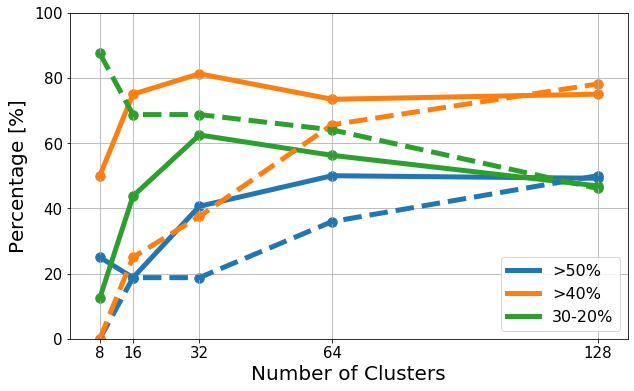

In [64]:
# Compare!
labels = ['>50%', '>40%', '30-20%']
plt.rcParams.update({'font.size': 15})
nclusters = np.array([8,16,32,64,128])

plt.figure(figsize=(10,6))
# large_hac2
for idx, thres in enumerate(nthres_list):
    plt.plot([8,16,32,64,128], np.array(thres)/nclusters*100,
             label=labels[idx], linewidth=5)
    plt.scatter([8,16,32,64,128], np.array(thres)/nclusters*100, s=90)

# large_hac1    
for idx, thres in enumerate(onthres_list):
    plt.plot([8,16,32,64,128], np.array(thres)/nclusters*100,
                linestyle='--',linewidth=5, color=f'C{idx}')
    plt.scatter([8,16,32,64,128], np.array(thres)/nclusters*100, s=90, color=f'C{idx}')


plt.xticks([8,16,32,64,128])
plt.grid(True)
plt.legend(fontsize=16)
plt.ylabel(r'Percentage [$\%$]', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=20)
plt.ylim(0,100)
#plt.show()
pdf = PdfPages(f'./figs/comp_hac1hac2_clusterCumuloRatio.pdf')
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

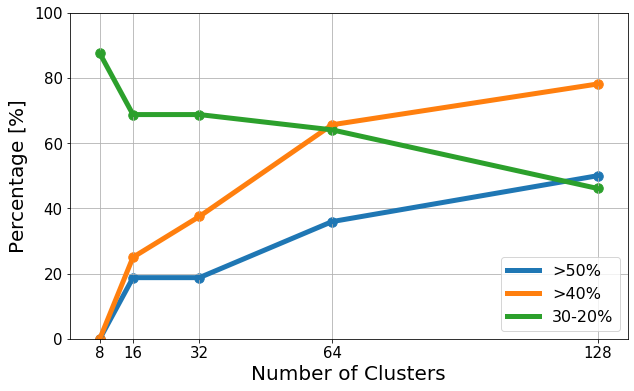

In [76]:
# Compare!
labels = ['>50%', '>40%', '30-20%']
plt.rcParams.update({'font.size': 15})
nclusters = np.array([8,16,32,64,128])

plt.figure(figsize=(10,6))
# large_hac2
for idx, thres in enumerate(onthres_list):
    plt.plot([8,16,32,64,128], np.array(thres)/nclusters*100,
             label=labels[idx], linewidth=5)
    plt.scatter([8,16,32,64,128], np.array(thres)/nclusters*100, s=90)

plt.xticks([8,16,32,64,128])
plt.grid(True)
plt.legend(fontsize=16)
plt.ylabel(r'Percentage [$\%$]', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=20)
plt.ylim(0,100)
#plt.show()
pdf = PdfPages(f'./figs/large_hac1_clusterCumuloRatio.pdf')
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

----------------------------------------
## OLD code (large_hac1)

In [ ]:
label_results = {}
databasedir = '/home/tkurihana/Research/CUMULO/clustering/large_hac2'  # large_hac1
for nclusters in nclusters_list:
    tmp_label_results = {}
    if nclusters > 8:
        for layer_name in layer_names:
            hac_datadir = f"{databasedir}/67011582/nclusters-{nclusters}/HAC/{layer_name}"
        
            # load data
            with open(os.path.join(hac_datadir,"score-hac_67011582.pkl"), 'rb') as f:
                results = pickle.load(f)
            #
            tmp_label_results[f"{layer_name}-labels"] = results[f'{layer_name}-labels']
    elif nclusters == 8:
        hac_datadir = f"{databasedir}/67011582/nclusters-8/HAC"
        with open(os.path.join(hac_datadir,"score-hac_67011582.pkl"), 'rb') as f:
            results = pickle.load(f)
        tmp_label_results = {}
        for layer_name in layer_names:
            for ikey in results.keys():
                if '-labels' in ikey:
                    if ikey.rstrip('-labels') == layer_name:
                        tmp_label_results[f"{layer_name}-labels"] =  results[ikey]
    label_results[f"{nclusters}"] = tmp_label_results

In [1]:
import numpy as np
import pickle
import os

In [2]:
hac_datadir='./large_hac1/67011582/nclusters-8/HAC'

In [3]:
with open(os.path.join(hac_datadir,"score-hac_67011582.pkl"), 'rb') as f:
        results = pickle.load(f)

In [4]:
results.keys()

dict_keys(['encoder-labels', 'encoder-rep', 'leaky_re_lu_15-labels', 'leaky_re_lu_15-rep', 'leaky_re_lu_16-labels', 'leaky_re_lu_16-rep', 'leaky_re_lu_17-labels', 'leaky_re_lu_17-rep', 'leaky_re_lu_18-labels', 'leaky_re_lu_18-rep', 'leaky_re_lu_19-labels', 'leaky_re_lu_19-rep', 'leaky_re_lu_20-labels', 'leaky_re_lu_20-rep', 'leaky_re_lu_21-labels', 'leaky_re_lu_21-rep', 'leaky_re_lu_22-labels', 'leaky_re_lu_22-rep', 'leaky_re_lu_23-labels', 'leaky_re_lu_23-rep', 'leaky_re_lu_24-labels', 'leaky_re_lu_24-rep', 'leaky_re_lu_25-labels', 'leaky_re_lu_25-rep', 'leaky_re_lu_26-labels', 'leaky_re_lu_26-rep', 'leaky_re_lu_27-labels', 'leaky_re_lu_27-rep'])

In [12]:
save_datadir='./large_hac1/67011582/nclusters-8/HAC'

In [13]:
os.makedirs(os.path.join(save_datadir, 'leaky_re_lu_23'), exist_ok=True)

In [14]:
layer_names = ['encoder-labels', 'encoder-rep', 'leaky_re_lu_23-labels', 'leaky_re_lu_23-rep']

In [15]:
local_results = {}
for layer_name in layer_names:
    local_results[layer_name] = results[layer_name]

In [16]:
with open(os.path.join(save_datadir, 'leaky_re_lu_23/score-hac_67011582.pkl'), 'wb' ) as f:
    pickle.dump(local_results, f)

In [7]:
hac_datadir='./large_hac1/67011582/nclusters-16/HAC'

In [10]:
with open(os.path.join(hac_datadir+'/leaky_re_lu_23',"score-hac_67011582.pkl"), 'rb') as f:
        results2 = pickle.load(f)

In [11]:
results2.keys()

dict_keys(['encoder-labels', 'encoder-rep', 'leaky_re_lu_23-labels', 'leaky_re_lu_23-rep'])

-----------------

In [28]:
gc.collect()

24

Check outputs in dict

In [19]:
label_results.keys()

dict_keys(['8', '16', '32', '64', '128'])

In [20]:
label_results['8'].keys()

dict_keys(['leaky_re_lu_15-labels', 'leaky_re_lu_23-labels'])

In [22]:
label_results['8']['leaky_re_lu_23-labels'].shape

(14699,)

In [27]:
label_results['16']['leaky_re_lu_23-labels'].shape

(14699,)

#### Load coordinate data from tfrecord patches

In [29]:
fileorder = np.load("./sort_file_names.npy")

In [30]:
tf_datadir = "/home/tkurihana/Research/data/tfrecords/clouds_MYD_CUMULO_label_20080101_timestamp"

In [31]:
coords_list = []
for i in fileorder:
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    ifile = os.path.join(tf_datadir, f"{fbasename}-label.tfrecord")
    _, tmp_coord_list = data_extractor_fn([ifile])
    coords_list.append(tmp_coord_list)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> fini

#### Load netcdf data from nc and npy files

In [32]:
netcdf_datadir = "/home/tkurihana/Research/data3/200801/day"

In [37]:
npy_datadir = "/home/tkurihana/Research/CUMULO/ml-examples/results/iresnet/6176413/best/predicted-label-masks"

In [38]:
longs = []
lats = []
data = []
idx = 20
for idx, i in enumerate(fileorder):
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    fbname = re.findall(r'A[0-9]{7}.[0-9]{4}', fbasename)[0].split('.')
    ctime = fbname[1]
    ifile = os.path.join(
        netcdf_datadir,f"A2008.001.{ctime}.nc"
    )
    # coord
    longs.append(importNetcdf(ifile, 'longitude'))
    lats.append(importNetcdf(ifile, 'latitude'))
    data.append(np.load(os.path.join(npy_datadir, f"A2008.001.{ctime}.npy")))
    if idx % 20 == 0:
        print(f"{idx} files read done!", flush=True)
        gc.collect()

0 files read done!
20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!


In [68]:
gc.collect()

0

In [40]:
len(longs_list)

14699

#### Get number of representations

##### Extract data  from npy file: 

In [42]:
select_data = []
patch_size = 128
for idata, coords in zip(data, coords_list):
    for coord in coords:
        i,j = coord
        select_data.extend(idata[j:j+patch_size,i:i+patch_size].ravel())

##### Extract data from label data and multiple 128x128 times for matching predicted-ground-truth

In [46]:
"""
    data structure: label_results['16']['leaky_re_lu_23-labels'].shape

"""
mut_label_dict = {}
for nclusters in nclusters_list:
    tmp_mut_clabels = {}
    for layer_name in layer_names:
        mut_clabels = []
        for i in label_results[f'{nclusters}'][f"{layer_name}-labels"]:
            for j in range(patch_size*patch_size):
                mut_clabels.append(i)
        tmp_mut_clabels[f"{layer_name}-labels"] = mut_clabels
    mut_label_dict[f"{nclusters}"] = tmp_mut_clabels
print(len(mut_clabels))

240828416


#### Compute ratio of clouds types per cluster

In [49]:
def eval_fn(select_data, mut_clabels, nclusters=None, cumulos=8, ):
    indv_scores = {}
    sdata = np.array(select_data)
    mlabels = np.array(mut_clabels)
    for icluster in range(nclusters):
        idx = np.where(mlabels == icluster)
        _sdata = sdata[idx]
        tmp = {}
        for i in range(cumulos):
            tmp[f"nc-{i}"] = len(np.where(_sdata == i)[0] )
        indv_scores[f"{icluster}"] = tmp
        print(f" Cluster {icluster} finish!")
    return indv_scores

In [55]:
mut_label_dict.keys()

dict_keys(['8', '16', '32', '64', '128'])

In [59]:
len(mut_label_dict['8']['leaky_re_lu_15-labels'])

240828416

In [67]:
dict_ratios = {}
for nclusters in nclusters_list:
    for layer_name in layer_names:
        c_mut_clabels = mut_label_dict[f'{nclusters}'][f"{layer_name}-labels"]
        df_ratio = pd.DataFrame(eval_fn(
            select_data, c_mut_clabels, nclusters=nclusters, cumulos=8
            )
        )
        dict_ratios[f'{layer_name}-{nclusters}'] = df_ratio

 Cluster 0 finish!
 Cluster 1 finish!
 Cluster 2 finish!
 Cluster 3 finish!
 Cluster 4 finish!
 Cluster 5 finish!
 Cluster 6 finish!
 Cluster 7 finish!
 Cluster 0 finish!
 Cluster 1 finish!
 Cluster 2 finish!
 Cluster 3 finish!
 Cluster 4 finish!
 Cluster 5 finish!
 Cluster 6 finish!
 Cluster 7 finish!
 Cluster 0 finish!
 Cluster 1 finish!
 Cluster 2 finish!
 Cluster 3 finish!
 Cluster 4 finish!
 Cluster 5 finish!
 Cluster 6 finish!
 Cluster 7 finish!
 Cluster 8 finish!
 Cluster 9 finish!
 Cluster 10 finish!
 Cluster 11 finish!
 Cluster 12 finish!
 Cluster 13 finish!
 Cluster 14 finish!
 Cluster 15 finish!
 Cluster 0 finish!
 Cluster 1 finish!
 Cluster 2 finish!
 Cluster 3 finish!
 Cluster 4 finish!
 Cluster 5 finish!
 Cluster 6 finish!
 Cluster 7 finish!
 Cluster 8 finish!
 Cluster 9 finish!
 Cluster 10 finish!
 Cluster 11 finish!
 Cluster 12 finish!
 Cluster 13 finish!
 Cluster 14 finish!
 Cluster 15 finish!
 Cluster 0 finish!
 Cluster 1 finish!
 Cluster 2 finish!
 Cluster 3 finish!


 Cluster 46 finish!
 Cluster 47 finish!
 Cluster 48 finish!
 Cluster 49 finish!
 Cluster 50 finish!
 Cluster 51 finish!
 Cluster 52 finish!
 Cluster 53 finish!
 Cluster 54 finish!
 Cluster 55 finish!
 Cluster 56 finish!
 Cluster 57 finish!
 Cluster 58 finish!
 Cluster 59 finish!
 Cluster 60 finish!
 Cluster 61 finish!
 Cluster 62 finish!
 Cluster 63 finish!
 Cluster 64 finish!
 Cluster 65 finish!
 Cluster 66 finish!
 Cluster 67 finish!
 Cluster 68 finish!
 Cluster 69 finish!
 Cluster 70 finish!
 Cluster 71 finish!
 Cluster 72 finish!
 Cluster 73 finish!
 Cluster 74 finish!
 Cluster 75 finish!
 Cluster 76 finish!
 Cluster 77 finish!
 Cluster 78 finish!
 Cluster 79 finish!
 Cluster 80 finish!
 Cluster 81 finish!
 Cluster 82 finish!
 Cluster 83 finish!
 Cluster 84 finish!
 Cluster 85 finish!
 Cluster 86 finish!
 Cluster 87 finish!
 Cluster 88 finish!
 Cluster 89 finish!
 Cluster 90 finish!
 Cluster 91 finish!
 Cluster 92 finish!
 Cluster 93 finish!
 Cluster 94 finish!
 Cluster 95 finish!


##### Transform raw data to percentage

df = (dict_ratios[f'{column_name}'] / dict_ratios[f'{column_name}'].sum()) * 100

#### See raw data-table as csv

In [69]:
dict_ratios.keys()

dict_keys(['leaky_re_lu_15-8', 'leaky_re_lu_23-8', 'leaky_re_lu_15-16', 'leaky_re_lu_23-16', 'leaky_re_lu_15-32', 'leaky_re_lu_23-32', 'leaky_re_lu_15-64', 'leaky_re_lu_23-64', 'leaky_re_lu_15-128', 'leaky_re_lu_23-128'])

In [71]:
type(dict_ratios['leaky_re_lu_15-8'])

pandas.core.frame.DataFrame

In [72]:
dict_ratios['leaky_re_lu_15-8']

,0,1,2,3,4,5,6,7
nc-0,7051016,13826004,6813639,3530876,12052880,4793026,5582191,1149903
nc-1,4370680,10886701,876439,43437,1255907,28536,6902021,34640
nc-2,2724232,2891839,2958669,4442995,5187919,4986042,3307385,1307312
nc-3,1137548,357601,3402041,2566713,1445687,406511,3306105,2273699
nc-4,11212628,4085899,9170667,16057516,14634161,17853456,16268753,5674843
nc-5,400613,288697,288144,637799,730256,1865949,447207,124764
nc-6,2381491,6345883,165281,24,99014,48,10192610,2519
nc-7,0,0,0,0,0,0,0,0


#### Save dataframe as csv files

In [89]:
dict_ratios[ikey].columns[0]

'0'

In [96]:

csv_datadir = './csvs'
os.makedirs(csv_datadir, exist_ok=True)
for ikey in dict_ratios.keys():
    dict_ratios[ikey].to_csv(os.path.join(csv_datadir, f'raw-{ikey}.csv'))
    df = dict_ratios[ikey]
    for idx in dict_ratios[ikey].columns:
        df[f"{idx}"] = (df[f"{idx}"]/df[f"{idx}"].sum())*100
        df[f"{idx}"] = df[f"{idx}"].round(2)
    df.to_csv(os.path.join(csv_datadir, f'ratio-{ikey}.csv'))

----------------------------
### Add ratio analysis
ratio of standard cloud classes in our novel clusters

#### Load data

In [7]:
data_list = []
for nc in [12]:  #[8,16,32,64,128]:
    adf = pd.read_csv(
            f'./csvs/large_hac2/ratio-leaky_re_lu_23-{nc}.csv', index_col=0
        )
    adf.index = ['Ci', 'As', 'Ac', 'St', 'Sc', 'Cu', 'Ns', 'Dc']
    adf.columns = [f"nc-{str(i)}" for i in range(nc) ]
    data_list.append(adf)

In [8]:
data_list[0]

,nc-0,nc-1,nc-2,nc-3,nc-4,nc-5,nc-6,nc-7,nc-8,nc-9,nc-10,nc-11
Ci,32.83,47.38,20.69,35.20,28.78,24.15,43.28,15.20,7.14,15.97,35.61,16.04
As,6.19,21.17,43.76,1.49,20.99,0.08,7.02,12.90,0.08,17.83,2.20,0.10
Ac,13.35,8.42,0.73,16.31,6.52,12.54,10.07,6.83,10.29,6.08,9.90,12.01
St,10.55,1.10,0.02,7.67,4.22,2.32,5.00,14.37,21.70,1.17,5.65,12.32
Sc,34.30,13.52,0.43,37.72,20.73,58.02,32.85,45.00,59.49,23.43,45.05,58.43
Cu,1.28,0.91,0.05,1.60,0.80,2.89,1.11,0.89,1.30,0.80,1.56,1.10
Ns,1.50,7.51,34.31,0.01,17.95,0.00,0.68,4.80,0.00,34.72,0.03,0.00
Dc,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [9]:
def gen_isccp_grid(df, nclusters=None, 
                 isccps=['Ci', 'Ci','Dc','Ac','As','Ns', 'Cu','Sc','St'], ):
    nc_heat_list = []
    for icluster in range(nclusters):
        # initialization
        i = 0; j = 0; harray = np.ones((3,3))
        for isccp in isccps:
            atmp = df["nc-"+str(icluster)]
            #print(atmp)
            tmp = atmp.loc[isccp]
            #print(tmp)
            harray[i,j] = round(float(tmp),2)
            j+=1
            if j == 3:
                i+=1
                j=0
        nc_heat_list.append(harray)
    return nc_heat_list

In [10]:
math.ceil(1.2)

2

In [11]:
def plot_isccps(df_data, nclusters=None,figsize=(12,8),cmap=None,annot_size=None,lc=None,
                font_scale=None,stride=64,savedir='./figs', titlefsize=14):
    fig = plt.figure(figsize=figsize)
    nfig = math.ceil(np.sqrt(nclusters))
    sns.set_theme(style="white",font_scale=font_scale)
    
    labels = np.array([
        ['Ci', 'Cs','Dc'],
        ['Ac','As','Ns'],
        ['Cu','Sc','St']
    ])
    
    hmap_list = []
    hmap_list = gen_isccp_grid(df_data, nclusters=nclusters)
    for idx, hmap in enumerate(hmap_list):
        ax = plt.subplot(nfig, nfig, idx+1)        
        mask = np.zeros_like(hmap)
        mask[np.where(hmap < 1.0)] = True
        with sns.axes_style("white"):
            sns.heatmap(hmap, mask=mask, linewidths=.5,linecolor=lc,
                        ax=ax, cmap=cmap,square=True,annot=labels,fmt="",
                       annot_kws={'size': annot_size},)
            
        # fix sns and mpl incomatible
        b, t = ax.set_ylim() # discover the values for bottom and top
        b += .55 # Add 0.5 to the bottom
        t -= .55 # Subtract 0.5 from the top
        ax.set_ylim(b, t) # update the ylim(bottom, top) values
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(f"{idx}", fontsize=titlefsize)
    
    fig.tight_layout()
    #plt.show()
    #ax.set_ylabel('Bhattacharyya',fontsize=20)
    pdf = PdfPages(os.path.join(savedir, f"isccp-cluster-table_{nclusters}_stride-{stride}.pdf") )
    plt.savefig(pdf, format='pdf', bbox_inches='tight')
    pdf.close()
    pdf = None

In [ ]:
plot_isccps(data_list[0], nclusters=8,figsize=(20,17), cmap='YlGn', 
            annot_size=40, font_scale=2.5, titlefsize=35)

In [ ]:
plot_isccps(data_list[2], nclusters=32,figsize=(20,17), cmap='YlGn', annot_size=22, 
            font_scale=2., titlefsize=22)

------------
### Paper version: Integrate all colorbar and standard color scheme

In [111]:
def plot_isccps_paper(df_data, nclusters=None,figsize=(12,8),cmap=None,annot_size=None,sq=True,
                      lc=None,lw=.5,font_scale=None,tcs=[],
                      stride=64,savedir='./figs', titlefsize=14, vmin=0, vmax=40, position=[]):
    """  ISSUE: https://github.com/mwaskom/seaborn/issues/373
    """
    fig = plt.figure(figsize=figsize)
    plt.rcParams["axes.grid"] = False
    nfig = math.ceil(np.sqrt(nclusters))
    #fig, ax = plt.subplots(nfig, nfig, figsize=figsize) 
    sns.set_theme(style="white",font_scale=font_scale)
    #sns.set_theme(font_scale=font_scale)
    #sns.set_style("whitegrid", {'axes.grid' : False},)
    
    labels = np.array([
        ['', '','Dc'],
        ['Ac','As','Ns'],
        ['Cu','Sc','St']
    ])
    
    if len(tcs) == 0:
        tcs = ["black" for i in range(nclusters)]
    
    hmap_list = []
    hmap_list = gen_isccp_grid(df_data, nclusters=nclusters)
    images = []
    ax = []
    for idx, hmap in enumerate(hmap_list):
        iax = plt.subplot(nfig, nfig, idx+1)        
        ax.append(iax)
        mask = np.zeros_like(hmap)
        mask[np.where(hmap < 1.0)] = True
        #with sns.axes_style("white"):
        im = sns.heatmap(hmap, mask=mask, linewidths=lw,linecolor=lc,
                        ax=iax, cmap=cmap,square=sq,annot=labels,fmt="",
                       annot_kws={'size': annot_size},cbar=False, vmin=vmin, vmax=vmax)
        images.append(im)
            
            #
            #make frame visible
            #for _, spine in im.spines.items():
            #    spine.set_visible(True)
            #    #iax.set_visible(True)
            
        # fix sns and mpl incomatible
        b, t = iax.set_ylim() # discover the values for bottom and top
        b += .5 # Add 0.5 to the bottom
        t -= .5 # Subtract 0.5 from the top
        #b += .55 # Add 0.5 to the bottom
        #t -= .55 # Subtract 0.5 from the top
        iax.set_ylim(b, t) # update the ylim(bottom, top) values
        
        
        iax.xaxis.set_visible(False)
        iax.yaxis.set_visible(False)
        iax.set_title(f"{idx+1}", fontsize=titlefsize)
        # Ci/Cs label
        iax.text(.6,.6,"Ci/Cs", fontsize= annot_size*1.0, color=tcs[idx])
        #make frame visible
        for _, spine in im.spines.items():
            spine.set_visible(True)
    
    mappable = im.get_children()[0]
    cax = plt.axes(position)  # [left, bottom, width, height]
    cbar = fig.colorbar(mappable, cax = cax,orientation = 'horizontal',ticks=np.arange(0,vmax+1,10))
    #cbar.ax.set_yticklabels([f"{i}%" for i in np.arange(0,vmax+1,10)])
    cbar.set_ticklabels([f"{i}%" for i in np.arange(0,vmax+1,10)])
    cbar.ax.tick_params(labelsize=annot_size)
    cbar.set_label(label='Percentage of overlap', size=annot_size)
    
    
    
    # save
    fig.tight_layout(pad=0.3,h_pad=0.3)
    #plt.show()
    #ax.set_ylabel('Bhattacharyya',fontsize=20)
    pdf = PdfPages(os.path.join(savedir, f"isccp-cluster-table_{nclusters}_stride-{stride}.pdf") )
    plt.savefig(pdf, format='pdf', bbox_inches='tight')
    pdf.close()
    pdf = None

In [223]:
def plot_isccps_paper(df_data, nclusters=None,figsize=(12,8),cmap=None,annot_size=None,sq=True,
                      lc=None,lw=.5,font_scale=None,tcs=[],dx=.2,dy=.2,cct=20,
                      stride=64,savedir='./figs', titlefsize=14, vmin=0, vmax=40, position=[]):
    """  ISSUE: https://github.com/mwaskom/seaborn/issues/373
    """
    fig = plt.figure(figsize=figsize)
    plt.rcParams["axes.grid"] = False
    nfig = math.ceil(np.sqrt(nclusters))
    #fig, ax = plt.subplots(nfig, nfig, figsize=figsize) 
    sns.set_theme(style="white",font_scale=font_scale)
    
    cmap = cm = plt.cm.get_cmap(cmap)
    cmap.set_under('white')
    
    labels = ['', '','Dc']+['Ac','As','Ns']+['Cu','Sc','St']
    
    if len(tcs) == 0:
        tcs = ["black" for i in range(nclusters)]
    
    hmap_list = []
    hmap_list = gen_isccp_grid(df_data, nclusters=nclusters)
    images = []
    ax = []
    # if matplotlib
    xy = [(j+.4,i+.4) for i in range(3) for j in range(3)]
    for idx, hmap in enumerate(hmap_list):
        iax = plt.subplot(3,nfig, idx+1)        
        ax.append(iax)
        #mask = np.zeros_like(hmap)
        mask = np.ones_like(hmap)
        mask[np.where(hmap <= 1.0)] =  -10000 #True
        # MATPLOTLIB
        #print(type(hmap) ); stop
        hmap[np.where(hmap <= 1.0)] = -99
        im = iax.pcolor(hmap,linewidths=lw,edgecolors=lc,cmap=cmap,rasterized=True,
                        vmin=vmin, vmax=vmax,antialiaseds=False)
        iax.invert_yaxis()
        # if matplotlib
        _hmap = hmap.ravel()
        for iid, (ix, iy) in enumerate(xy):
            l = labels[iid] if _hmap[iid] > 1 else ""
            cc = "white" if _hmap[iid] > cct else "black"
            iax.text(ix+dx, iy+dy, l,  fontsize= annot_size*1.0, color=cc,) 
        images.append(im)

        
        iax.xaxis.set_visible(False)
        iax.yaxis.set_visible(False)
        iax.set_title(f"{idx+1}", fontsize=titlefsize)
        # Ci/Cs label
        iax.text(.6,.6,"Ci/Cs", fontsize= annot_size*1.0, color=tcs[idx])
        #make frame visible
        #for _, spine in im.spines.items():
        #    spine.set_visible(True)
    
    mappable = images[0] #im.get_children()[0]
    cax = plt.axes(position)  # [left, bottom, width, height]
    cbar = fig.colorbar(mappable, cax = cax,orientation = 'horizontal',ticks=np.arange(0,vmax+1,10))
    #cbar.ax.set_yticklabels([f"{i}%" for i in np.arange(0,vmax+1,10)])
    cbar.set_ticklabels([f"{i}%" for i in np.arange(0,vmax+1,10)])
    cbar.ax.tick_params(labelsize=annot_size)
    cbar.set_label(label='Percentage of overlap', size=annot_size)
    
    
    
    # save
    fig.tight_layout(pad=0.5,h_pad=0.5)
    #plt.show()
    #ax.set_ylabel('Bhattacharyya',fontsize=20)
    pdf = PdfPages(os.path.join(savedir, f"isccp-cluster-table_{nclusters}_stride-{stride}.pdf") )
    plt.savefig(pdf, format='pdf', bbox_inches='tight')
    pdf.close()
    pdf = None

In [ ]:
plot_isccps_paper(data_list[2], nclusters=32,figsize=(16,16), cmap='YlGn', annot_size=22,vmax=40, 
            font_scale=1.8, titlefsize=22, position=[0.4, 0.075, 0.55, 0.0375])

##### Cluster = 12 after consider non cloud pixels

In [32]:
tcs = [ "white"  if idx in [0,1,3,4,5,6,10] else 'black' for idx, c in enumerate(["black" for i in range(12)]) ]

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


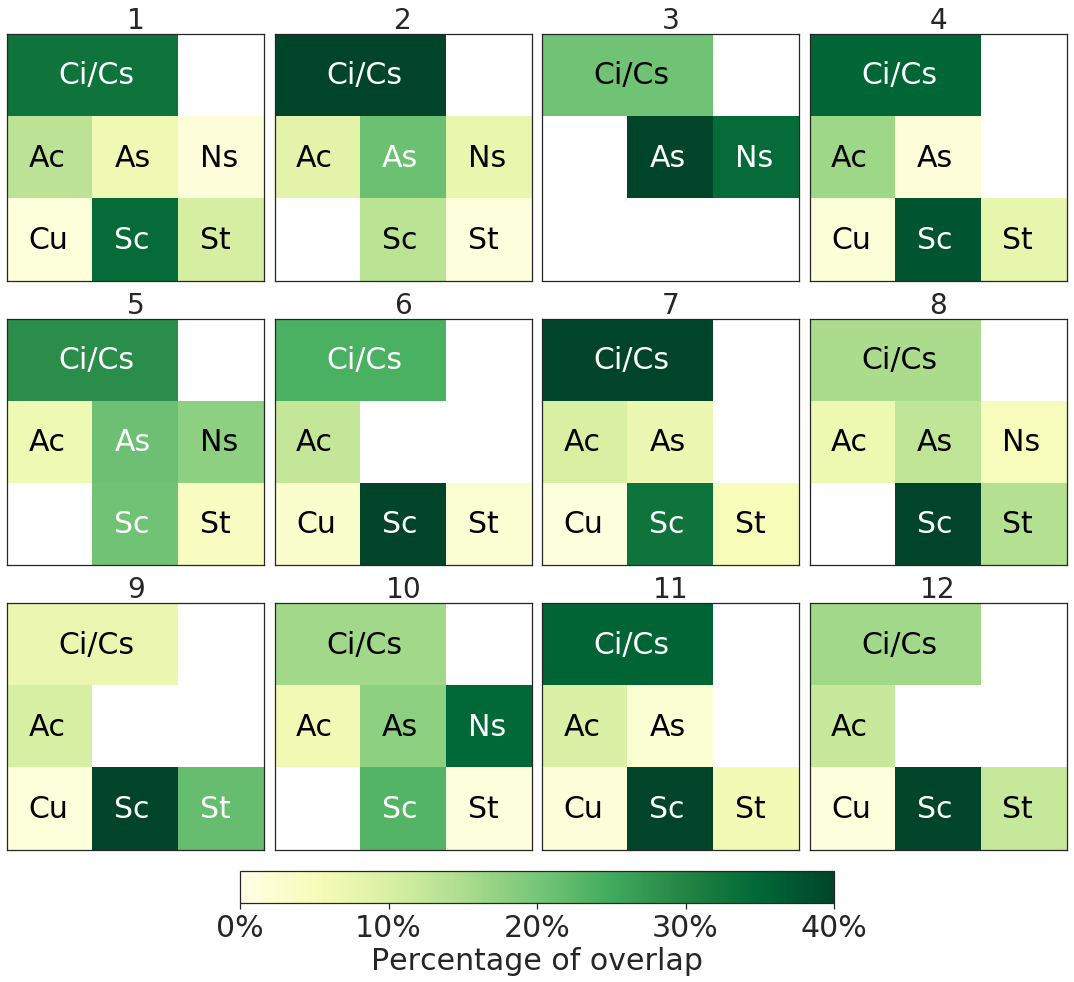

In [225]:
plot_isccps_paper(data_list[0], nclusters=12,figsize=(15,12), cmap='YlGn', annot_size=30,vmax=40, lw=0.00,lc=None,
                  dx=-.15, dy=.2,cct=20,
                  tcs=tcs,sq=False, font_scale=1.7, titlefsize=28, position=[0.225, -0.05, 0.55, 0.0375], )
#[0.2, 0.2, 0.55, 0.0375]